## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

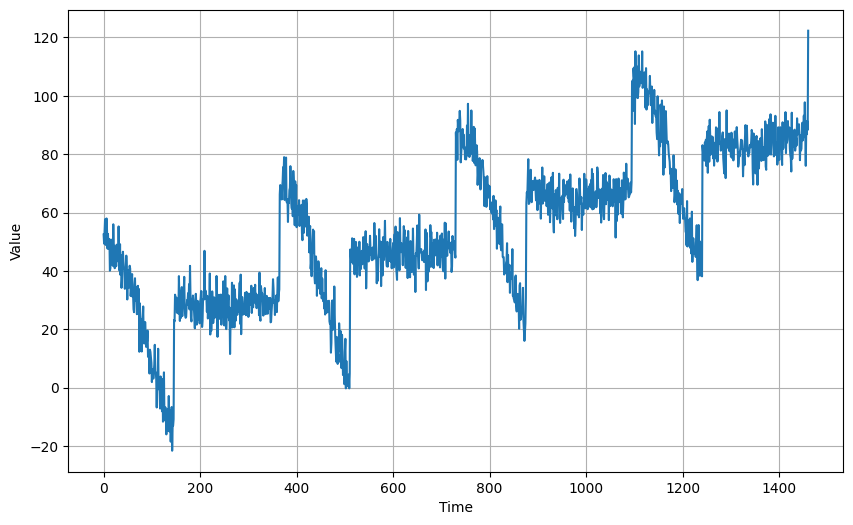

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN Forecasting

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 157.6012 - mae: 158.1012 - learning_rate: 1.0000e-07
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 128.7724 - mae: 129.2724 - learning_rate: 1.1220e-07
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 75.4133 - mae: 75.9129 - learning_rate: 1.2589e-07
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 32.7523 - mae: 33.2488 - learning_rate: 1.4125e-07
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 33.9523 - mae: 34.4512 - learning_rate: 1.5849e-07
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 27.0594 - mae: 27.5546 - learning_rate: 1.7783e-07
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 24.6153 - mae: 25.1131 - learning_rate: 1.9953e-07
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 20.6085 - mae: 21.1037 - learning_rate: 2.2387e-07
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 16.8107 - mae: 17.3046 - learning_rate: 2.5119e-07
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 14.0868 - mae: 14.5762 - learning_rate: 2.8184e-07
Epoch 11/100
8/8 ━━━━━━━━

(1e-07, 0.0001, 0.0, 30.0)

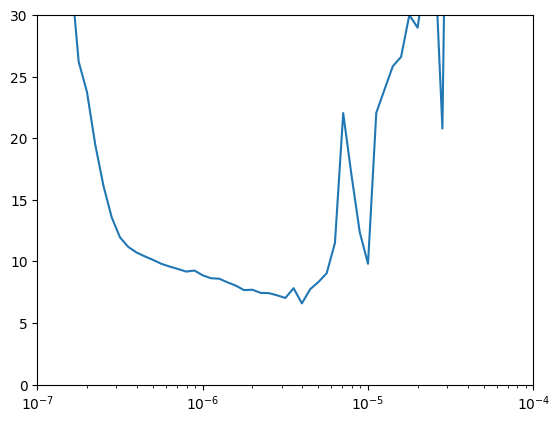

In [6]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [7]:
'''keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])'''

'keras.backend.clear_session()\ntf.random.set_seed(42)\nnp.random.seed(42)\n\nwindow_size = 30\ntrain_set = window_dataset(x_train, window_size, batch_size=128)\nvalid_set = window_dataset(x_valid, window_size, batch_size=128)\n\nmodel = keras.models.Sequential([\n  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),\n                      input_shape=[None]),\n  keras.layers.SimpleRNN(100, return_sequences=True),\n  keras.layers.SimpleRNN(100),\n  keras.layers.Dense(1),\n  keras.layers.Lambda(lambda x: x * 200.0)\n])\noptimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)\nmodel.compile(loss=keras.losses.Huber(),\n              optimizer=optimizer,\n              metrics=["mae"])\nearly_stopping = keras.callbacks.EarlyStopping(patience=50)\nmodel_checkpoint = keras.callbacks.ModelCheckpoint(\n    "my_checkpoint", save_best_only=True)\nmodel.fit(train_set, epochs=500,\n          validation_data=valid_set,\n          callbacks=[early_stopping, model_checkpoint])'

In [8]:
#model = keras.models.load_model("my_checkpoint")

In [9]:
#rnn_forecast = model_forecast(model,    series[split_time - window_size:-1],    window_size)[:, 0]

In [10]:
'''plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)'''

'plt.figure(figsize=(10, 6))\nplot_series(time_valid, x_valid)\nplot_series(time_valid, rnn_forecast)'

In [11]:
#keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

## Sequence-to-Sequence Forecasting

In [12]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]


In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 170.1964 - mae: 170.6963 - learning_rate: 1.0000e-07
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 127.2025 - mae: 127.7022 - learning_rate: 1.0798e-07
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 69.2002 - mae: 69.6987 - learning_rate: 1.1659e-07
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 58.8757 - mae: 59.3743 - learning_rate: 1.2589e-07
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 56.7202 - mae: 57.2182 - learning_rate: 1.3594e-07
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 49.5264 - mae: 50.0248 - learning_rate: 1.4678e-07
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 44.4172 - mae: 44.9137 - learning_rate: 1.5849e-07
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 40.9558 - mae: 41.4515 - learning_rate: 1.7113e-07
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 36.6052 - mae: 37.1010 - learning_rate: 1.8478e-07
Epoch 10/100
8/8 ━━━━━━━━━━

(1e-07, 0.0001, 0.0, 30.0)

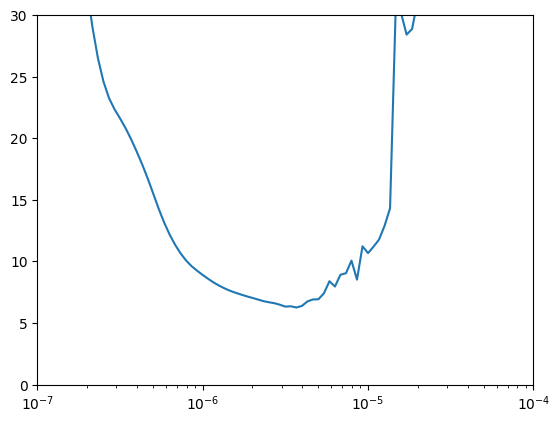

In [15]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 72.8906 - mae: 73.3889 - val_loss: 24.1037 - val_mae: 24.6002
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 50.9901 - mae: 51.4877 - val_loss: 45.0816 - val_mae: 45.5811
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 29.0985 - mae: 29.5938 - val_loss: 29.5026 - val_mae: 30.0015
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 22.3952 - mae: 22.8886 - val_loss: 15.7497 - val_mae: 16.2413
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 17.4723 - mae: 17.9615 - val_loss: 11.6972 - val_mae: 12.1830
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 15.8650 - mae: 16.3529 - val_loss: 11.4212 - val_mae: 11.9120
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 13.7314 - mae: 14.2168 - val_loss: 13.0479 - val_mae: 13.5398
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 12.9956 - mae: 13.4807 - val_loss: 10.9845 - val_mae: 11.4697
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s

In [17]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


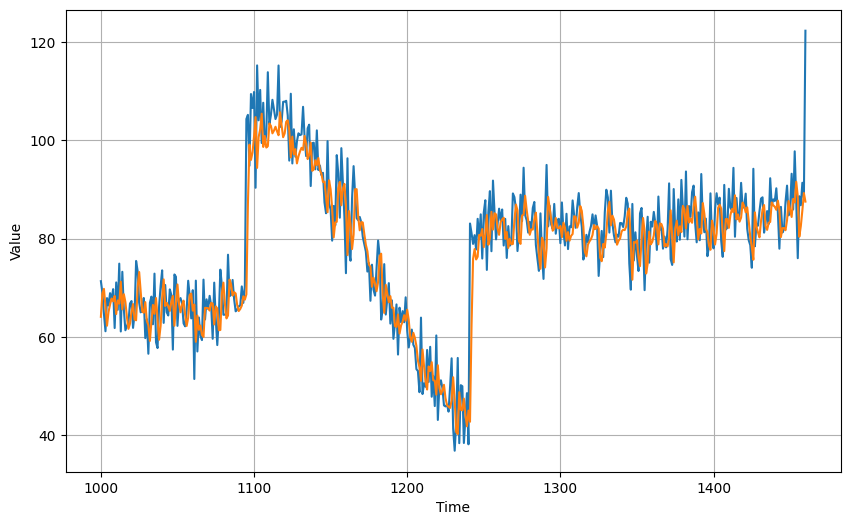

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [21]:
import keras
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.140417